In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

from pathlib import Path
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
import os

In [2]:
data_dir = Path('/home/dipu-dts/Desktop/Sales_Analysis/store-sales-time-series-forecasting')
data_dir

PosixPath('/home/dipu-dts/Desktop/Sales_Analysis/store-sales-time-series-forecasting')

In [3]:
holiday_events = pd.read_csv(data_dir / "holidays_events.csv") 
stores = pd.read_csv(data_dir / "stores.csv") 
test = pd.read_csv(data_dir / "test.csv") 
train = pd.read_csv(data_dir / "train.csv") 
transactions = pd.read_csv(data_dir / "transactions.csv")

In [4]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [5]:
df_data = pd.concat([train, test], sort=True)
df_data = df_data.merge(stores, how="left", on='store_nbr')   
# df_data = df_data.merge(oil, how="left", on='date')      
df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(holiday_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
df_data

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,POULTRY,3029395,1,NaN,9,Quito,Pichincha,B,6,...,NaN,NaN,NaN,NaN,NaN,2017,8,35,3,Thursday
3082856,2017-08-31,PREPARED FOODS,3029396,0,NaN,9,Quito,Pichincha,B,6,...,NaN,NaN,NaN,NaN,NaN,2017,8,35,3,Thursday
3082857,2017-08-31,PRODUCE,3029397,1,NaN,9,Quito,Pichincha,B,6,...,NaN,NaN,NaN,NaN,NaN,2017,8,35,3,Thursday
3082858,2017-08-31,SCHOOL AND OFFICE SUPPLIES,3029398,9,NaN,9,Quito,Pichincha,B,6,...,NaN,NaN,NaN,NaN,NaN,2017,8,35,3,Thursday


In [6]:
df_data.isnull().sum() * 100 / len(df_data)

date             0.000000
family           0.000000
id               0.000000
onpromotion      0.000000
sales            0.924855
store_nbr        0.000000
city             0.000000
state            0.000000
store_type       0.000000
cluster          0.000000
transactions     9.005566
holiday_type    83.641618
locale          83.641618
locale_name     83.641618
description     83.641618
transferred     83.641618
year             0.000000
month            0.000000
week             0.000000
quarter          0.000000
day_of_week      0.000000
dtype: float64

In [7]:
df_data.corr()
# sns.heatmap(df_data.corr(method='sales'))

,id,onpromotion,sales,store_nbr,cluster,transactions,year,month,week,quarter
id,1.000000,0.205995,0.086102,2.985703e-04,-4.329408e-05,-0.028106,9.782171e-01,7.404786e-02,7.537331e-02,7.345668e-02
onpromotion,0.205995,1.000000,0.428241,7.739773e-03,5.734068e-03,0.025809,1.990461e-01,2.692259e-02,2.388875e-02,2.621961e-02
sales,0.086102,0.428241,1.000000,4.127337e-02,3.853669e-02,0.214848,8.131982e-02,2.025001e-02,1.680398e-02,1.875173e-02
store_nbr,0.000299,0.007740,0.041273,1.000000e+00,-5.928399e-02,0.189656,2.074319e-14,-4.973560e-15,-5.080054e-15,-5.288405e-15
cluster,-0.000043,0.005734,0.038537,-5.928399e-02,1.000000e+00,0.196110,4.088561e-14,4.320017e-15,4.408324e-15,4.371601e-15
transactions,-0.028106,0.025809,0.214848,1.896558e-01,1.961100e-01,1.000000,-3.636347e-02,4.167727e-02,3.141177e-02,3.297441e-02
year,0.978217,0.199046,0.081320,2.074319e-14,4.088561e-14,-0.036363,1.000000e+00,-1.338153e-01,-1.264770e-01,-1.282107e-01
month,0.074048,0.026923,0.020250,-4.973560e-15,4.320017e-15,0.041677,-1.338153e-01,1.000000e+00,9.660882e-01,9.701099e-01
week,0.075373,0.023889,0.016804,-5.080054e-15,4.408324e-15,0.031412,-1.264770e-01,9.660882e-01,1.000000e+00,9.411099e-01
quarter,0.073457,0.026220,0.018752,-5.288405e-15,4.371601e-15,0.032974,-1.282107e-01,9.701099e-01,9.411099e-01,1.000000e+00


In [8]:
df_data.transactions = df_data.transactions.replace(np.nan,0)

In [9]:
sale_mean = df_data.sales.mean()
df_data.sales = df_data.sales.replace(np.nan, sale_mean)
df_data.sales.mean()

359.0208922513906

In [10]:
df_data.isnull().sum() * 100 / len(df_data)

date             0.000000
family           0.000000
id               0.000000
onpromotion      0.000000
sales            0.000000
store_nbr        0.000000
city             0.000000
state            0.000000
store_type       0.000000
cluster          0.000000
transactions     0.000000
holiday_type    83.641618
locale          83.641618
locale_name     83.641618
description     83.641618
transferred     83.641618
year             0.000000
month            0.000000
week             0.000000
quarter          0.000000
day_of_week      0.000000
dtype: float64

/home/dipu-dts/anaconda3/envs/time_series/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/dipu-dts/anaconda3/envs/time_series/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



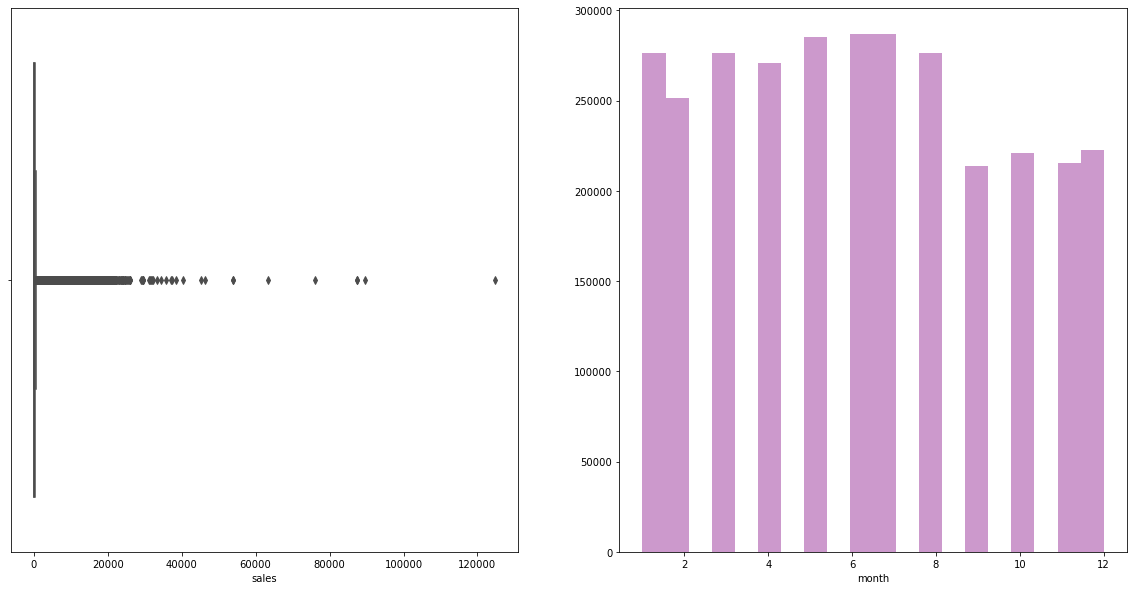

In [11]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.boxplot(df_data.sales, color='orange')
plt.subplot(1,2,2)
sns.distplot(df_data.month, bins=20, kde=False, color='purple')
plt.show()

In [12]:
df_data[['locale','locale_name', 'description']] = df_data[['locale','locale_name', 'description']].replace(np.nan,'')
df_data['holiday_type'] = df_data['holiday_type'].replace(np.nan,'Working Day')
df_data['transferred'] = df_data['transferred'].replace(np.nan,False)

In [13]:
df_st_sa = df_data[:train.shape[0]].groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fa_sa = df_data[:train.shape[0]].groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = df_data[:train.shape[0]].groupby('cluster').agg({"sales" : "mean"}).reset_index() 
# chart color
df_fa_sa['color'] = '#496595'
df_fa_sa['color'][2:] = '#c6ccd8'
df_cl_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], marker=dict(color= df_fa_sa['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], 
                     marker=dict(color= df_cl_sa['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [14]:
df_data.columns

Index(['date', 'family', 'id', 'onpromotion', 'sales', 'store_nbr', 'city',
       'state', 'store_type', 'cluster', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'year', 'month',
       'week', 'quarter', 'day_of_week'],
      dtype='object')

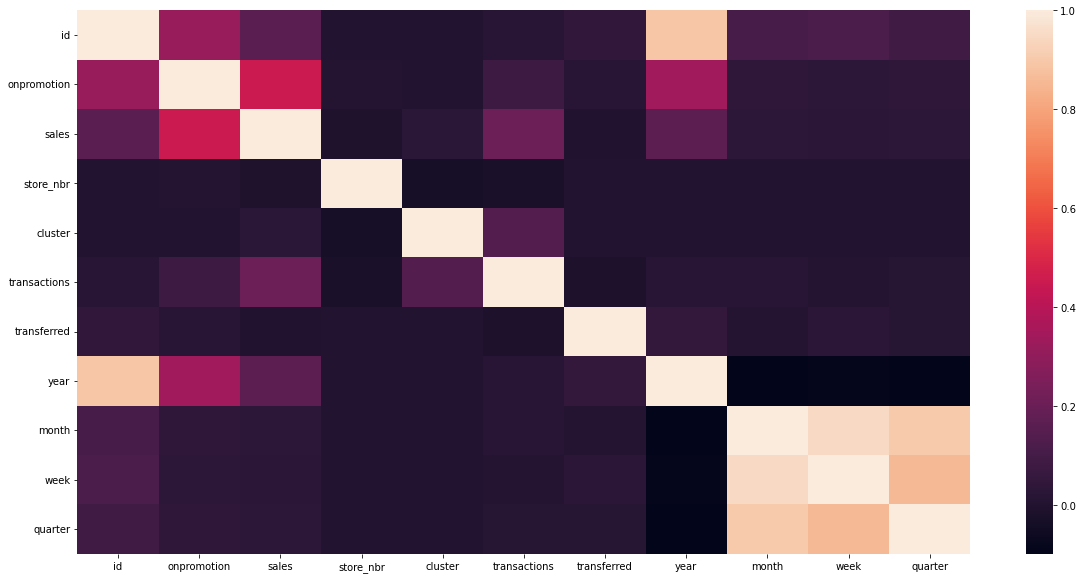

In [15]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_data.corr(method ='kendall'))
plt.show()

Interpret: Highest sales are made by the products like grocery and beverages. Store A has the highest sales which is 38%.

In [16]:
df_m_sa = df_data[:train.shape[0]].groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].astype(int).apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = df_data[:train.shape[0]].groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = df_data[:train.shape[0]].groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [17]:
# data
df_dw_sa = df_data[:train.shape[0]].groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

Text(0.5, 1.0, 'State vs Sales of Store A (per year)')

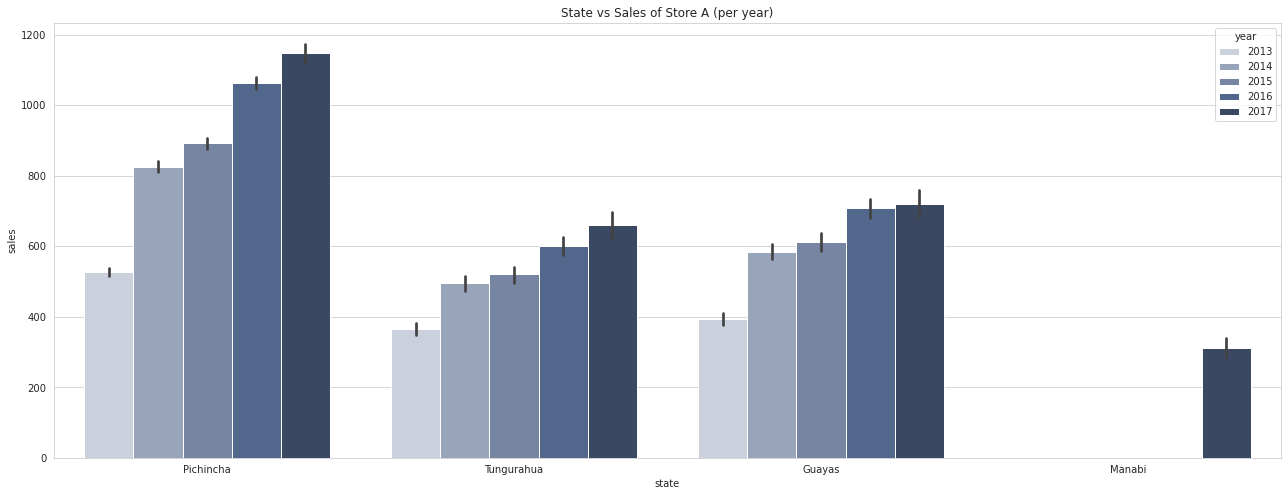

In [18]:
df_train = df_data[:train.shape[0]][['state','sales','store_type','year']]
fig = plt.figure(figsize=(22,8))
sns.set_style('whitegrid')
my_palette = ['#C8D0DF','#91A2BF','#6D83AA','#496595','#334668']
sns.barplot(x='state',y='sales',hue = 'year', palette = my_palette, data=df_train[df_train['store_type'] == 'A'])
plt.title("State vs Sales of Store A (per year)")

In [19]:
df_train

,state,sales,store_type,year
0,Pichincha,0.000,D,2013
1,Pichincha,0.000,D,2013
2,Pichincha,0.000,D,2013
3,Pichincha,0.000,D,2013
4,Pichincha,0.000,D,2013
...,...,...,...,...
3000883,Pichincha,571.333,B,2017
3000884,Pichincha,125.960,B,2017
3000885,Pichincha,2041.967,B,2017
3000886,Pichincha,0.000,B,2017


In [20]:
sales = df_data[:train.shape[0]].groupby('date').agg({"sales" : "mean"}).reset_index()
sales.set_index('date',inplace=True)
moving_average = sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)
moving_average['date'] = sales.index

fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08,                    
                    subplot_titles=("Sales 365 - Day Moving Average"))
fig.add_trace(go.Scatter(x=sales.index, y=sales['sales'], mode='lines', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#334668'), name='365-Day Moving Average'))
fig.add_trace(go.Scatter(x=moving_average.date,y=moving_average.sales,mode='lines',name='Trend'))
fig.update_layout(height=350, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Sales trend during years",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Text(0.5, 1.0, 'Seasonal Plot (year/dayofyear)')

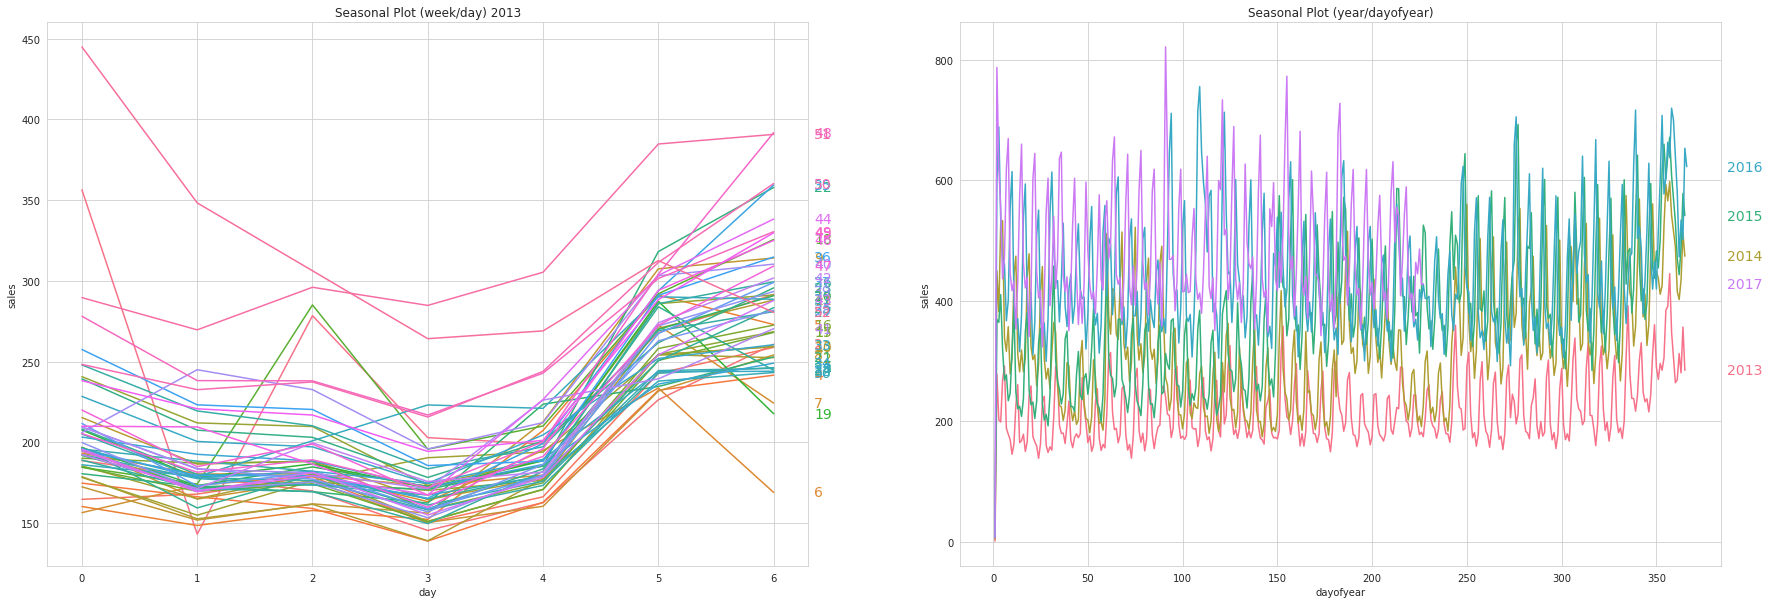

In [21]:
store_sales = pd.read_csv(data_dir / 
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    # .loc['2017']
)

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(30, 10))
seasonal_plot(X.loc['2013'], y='sales', period="week", freq="day", ax=ax0)
ax0.set_title('Seasonal Plot (week/day) 2013')
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
ax1.set_title('Seasonal Plot (year/dayofyear)')

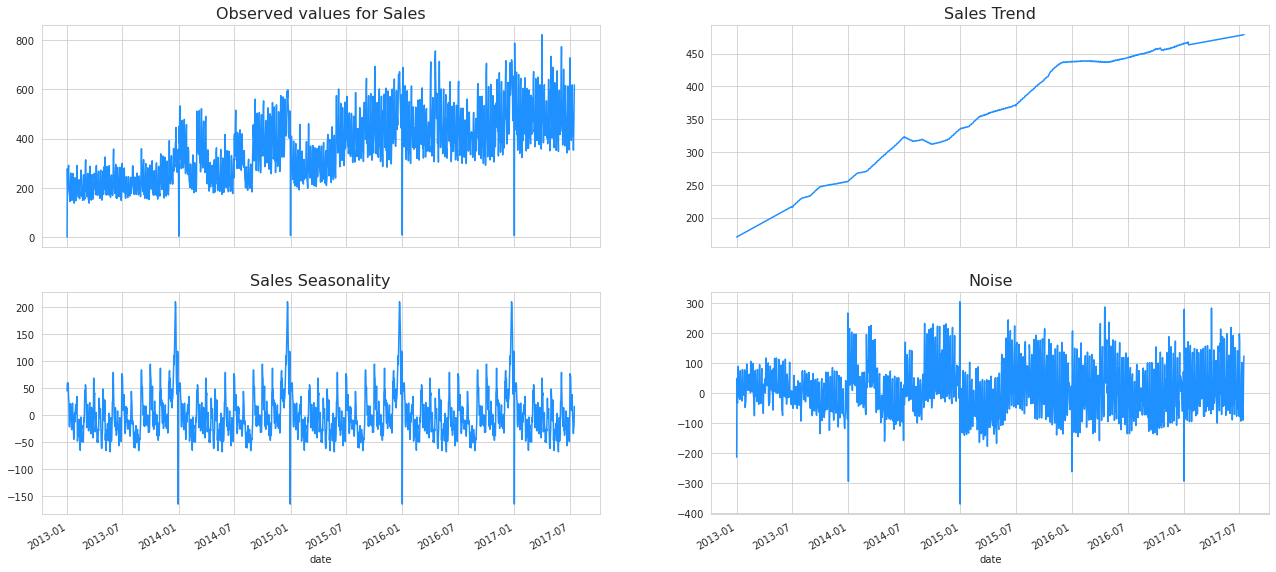

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(sales['sales'], period=365, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, color='dodgerblue')

ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, color='dodgerblue')

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, color='dodgerblue')

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, color='dodgerblue');

In [23]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
           
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [24]:
# Aggregating the Time Series to a monthly scaled index
y = df_data[['date','sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['sales'],title='') 

Augmented Dickey-Fuller Test: 
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<AxesSubplot:xlabel='date'>

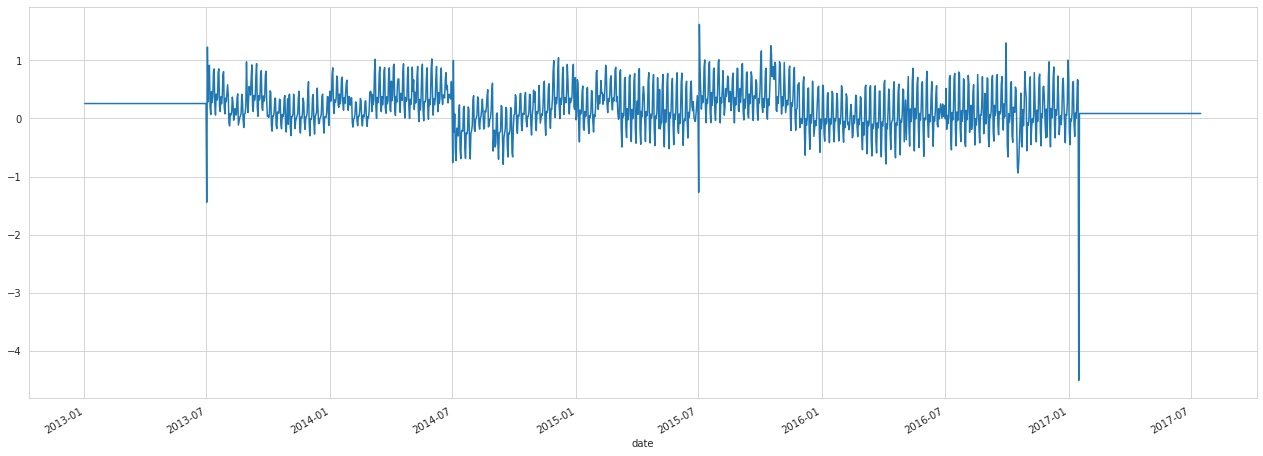

In [25]:
fig = plt.figure(figsize=(22,8))
decomp.trend.diff().plot()

In [26]:
non_numerical_cols =  [col for col in df_data.columns if df_data[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
df_data.head().style.set_properties(subset=non_numerical_cols, **{'background-color': 'black'})

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01 00:00:00,0,0,0,0.000000,1,18,12,3,13,0.000000,3,2,5,51,False,2013,1,1,1,5
1,2013-01-01 00:00:00,1,1,0,0.000000,1,18,12,3,13,0.000000,3,2,5,51,False,2013,1,1,1,5
2,2013-01-01 00:00:00,2,2,0,0.000000,1,18,12,3,13,0.000000,3,2,5,51,False,2013,1,1,1,5
3,2013-01-01 00:00:00,3,3,0,0.000000,1,18,12,3,13,0.000000,3,2,5,51,False,2013,1,1,1,5
4,2013-01-01 00:00:00,4,4,0,0.000000,1,18,12,3,13,0.000000,3,2,5,51,False,2013,1,1,1,5


In [27]:
from sklearn.model_selection import TimeSeriesSplit
N_SPLITS = 3

X = df_data['date']
y = df_data['sales']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [28]:
df_data.describe()

,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,year,month,week,quarter,day_of_week
count,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06,3.082860e+06
mean,1.600000e+01,1.518250e+06,2.657692e+00,3.590209e+02,2.750000e+01,1.255556e+01,8.796296e+00,2.000000e+00,8.481481e+00,1.544241e+03,5.418497e+00,2.693642e-01,1.387283e+00,5.992486e+00,2.014862e+03,6.239306e+00,2.538844e+01,2.419075e+00,3.006936e+00
std,9.521906e+00,8.742912e+05,1.236626e+01,1.102154e+03,1.558579e+01,6.264737e+00,4.165021e+00,1.201851e+00,4.649735e+00,1.042396e+03,1.390099e+00,6.551162e-01,3.952063e+00,1.734700e+01,1.355200e+00,3.362917e+00,1.470553e+01,1.092055e+00,1.995938e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.000000e+00,7.618048e+05,0.000000e+00,0.000000e+00,1.400000e+01,8.000000e+00,6.000000e+00,1.000000e+00,4.000000e+00,9.160000e+02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,3.000000e+00,1.300000e+01,1.000000e+00,1.000000e+00
50%,1.600000e+01,1.521828e+06,0.000000e+00,1.100000e+01,2.750000e+01,1.400000e+01,1.000000e+01,2.000000e+00,8.500000e+00,1.326000e+03,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03,6.000000e+00,2.500000e+01,2.000000e+00,3.000000e+00
75%,2.400000e+01,2.272940e+06,0.000000e+00,2.080000e+02,4.100000e+01,1.800000e+01,1.200000e+01,3.000000e+00,1.300000e+01,1.969000e+03,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.016000e+03,9.000000e+00,3.700000e+01,3.000000e+00,5.000000e+00
max,3.200000e+01,3.029399e+06,7.410000e+02,1.247170e+05,5.400000e+01,2.100000e+01,1.500000e+01,4.000000e+00,1.700000e+01,8.359000e+03,6.000000e+00,3.000000e+00,2.400000e+01,1.010000e+02,2.017000e+03,1.200000e+01,5.300000e+01,4.000000e+00,6.000000e+00


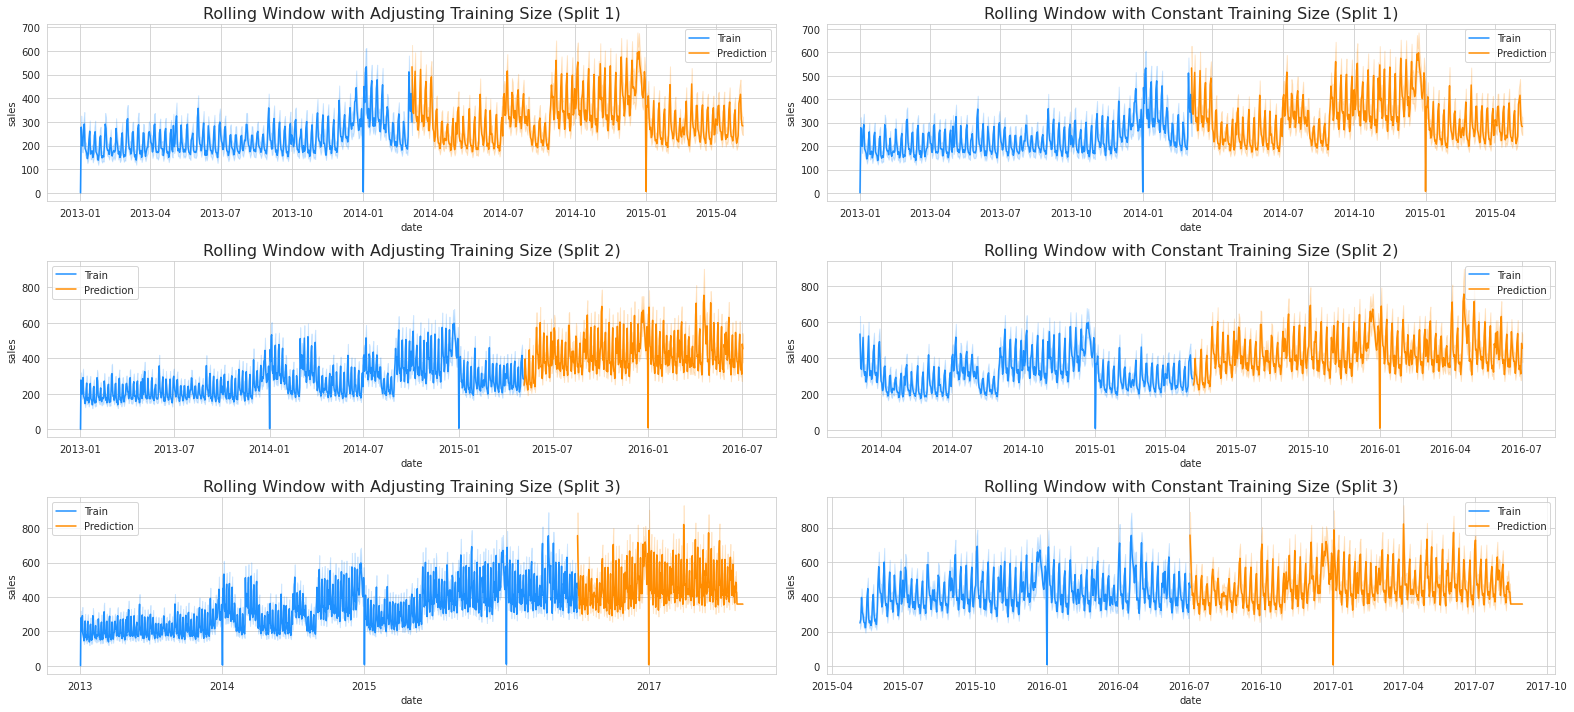

In [29]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(22, 10))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='Train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='Train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='Prediction')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error
import math

from fbprophet import Prophet

train = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales']].groupby('date').mean().reset_index('date')
train.columns = ['ds', 'y']
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,30)]['date'])
x_valid.columns = ['ds']

# Train the model
model = Prophet()
mdp = model.fit(train)

y_pred = mdp.predict(x_valid)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.0776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3507.69    0.00521671       256.598      0.6988      0.6988      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       3509.31   0.000178325       101.998   1.683e-06       0.001      251  LS failed, Hessian reset 
     199       3509.45   0.000391527       86.3506           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3510.62     0.0378401        139.53           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3512.65    3.6266e-05        77.056      0.2219      0.2219      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     444       3512.75   1.31769e-05    

In [31]:
#  Dump Model and Load model
import joblib
BASE_DIR = Path("/home/dipu-dts/Desktop/Sales_Analysis")

TODAY = datetime.date.today()
ticker = 'SSA'
joblib.dump(mdp, Path(BASE_DIR).joinpath(f"{ticker}.joblib"))

['/home/dipu-dts/Desktop/Sales_Analysis/SSA.joblib']

In [32]:
model_file = Path(BASE_DIR).joinpath(f"{ticker}.joblib")
model_load = joblib.load(model_file)
print(model_load)

In [33]:
prediction = model_load.predict(x_valid)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-08-30,504.996644,395.464623,552.601212,504.996644,504.996644,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.932120,-3.932120,-3.932120,0.0,0.0,0.0,476.251788
1,2017-08-30,504.996644,396.107923,549.192119,504.996644,504.996644,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.932120,-3.932120,-3.932120,0.0,0.0,0.0,476.251788
2,2017-08-30,504.996644,395.380548,551.923711,504.996644,504.996644,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.932120,-3.932120,-3.932120,0.0,0.0,0.0,476.251788
3,2017-08-30,504.996644,399.198808,557.375547,504.996644,504.996644,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.932120,-3.932120,-3.932120,0.0,0.0,0.0,476.251788
4,2017-08-30,504.996644,398.698255,553.495045,504.996644,504.996644,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.932120,-3.932120,-3.932120,0.0,0.0,0.0,476.251788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,2017-08-31,505.146273,356.874299,510.009674,505.144788,505.146273,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3560,2017-08-31,505.146273,349.026837,512.177805,505.144788,505.146273,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3561,2017-08-31,505.146273,352.119882,502.586013,505.144788,505.146273,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3562,2017-08-31,505.146273,356.291775,506.492837,505.144788,505.146273,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975


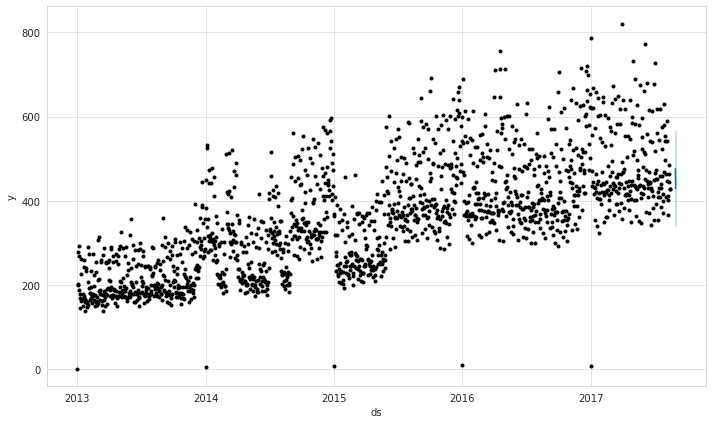

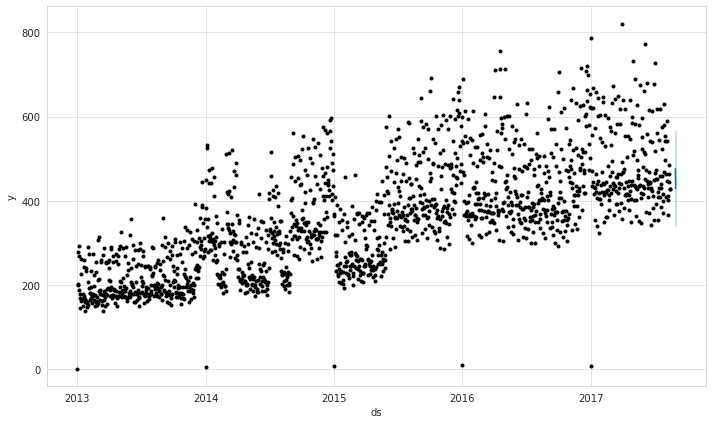

In [34]:
model_load.plot(prediction)

In [35]:
y_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3559,2017-08-31,505.146273,352.079089,504.250283,505.117096,505.180719,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3560,2017-08-31,505.146273,355.462040,506.271540,505.117096,505.180719,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3561,2017-08-31,505.146273,345.589680,507.469927,505.117096,505.180719,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3562,2017-08-31,505.146273,353.523057,506.899870,505.117096,505.180719,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975
3563,2017-08-31,505.146273,348.858598,506.351637,505.117096,505.180719,-75.991298,-75.991298,-75.991298,-74.010031,-74.010031,-74.010031,-1.981267,-1.981267,-1.981267,0.0,0.0,0.0,429.154975


In [36]:
y_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-08-30,504.996644,402.209045,557.453510,504.973794,505.017158,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.93212,-3.93212,-3.93212,0.0,0.0,0.0,476.251788
1,2017-08-30,504.996644,397.408785,551.778162,504.973794,505.017158,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.93212,-3.93212,-3.93212,0.0,0.0,0.0,476.251788
2,2017-08-30,504.996644,401.016562,555.367987,504.973794,505.017158,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.93212,-3.93212,-3.93212,0.0,0.0,0.0,476.251788
3,2017-08-30,504.996644,396.058850,551.545234,504.973794,505.017158,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.93212,-3.93212,-3.93212,0.0,0.0,0.0,476.251788
4,2017-08-30,504.996644,397.748480,553.341037,504.973794,505.017158,-28.744856,-28.744856,-28.744856,-24.812736,-24.812736,-24.812736,-3.93212,-3.93212,-3.93212,0.0,0.0,0.0,476.251788


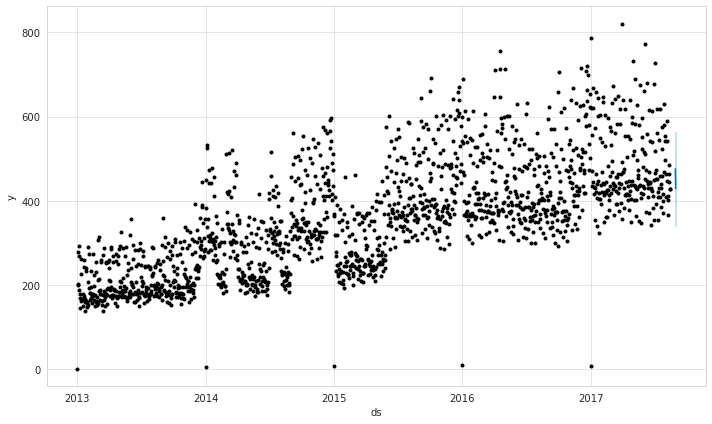

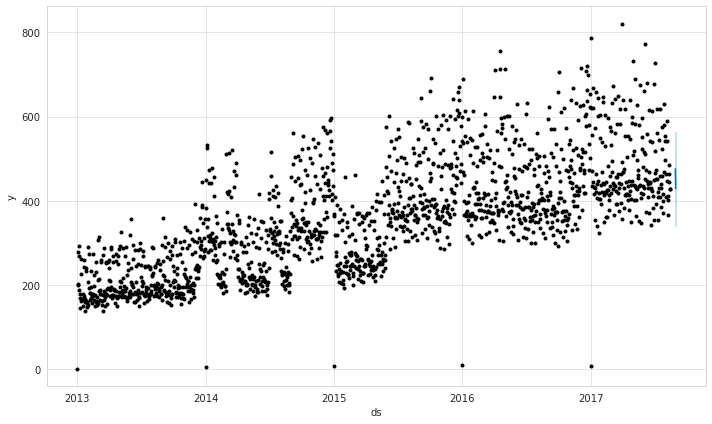

In [37]:
model.plot(y_pred)

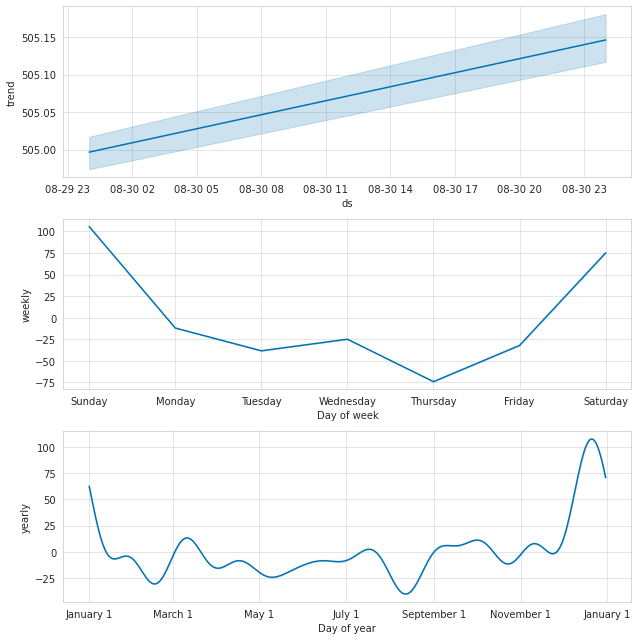

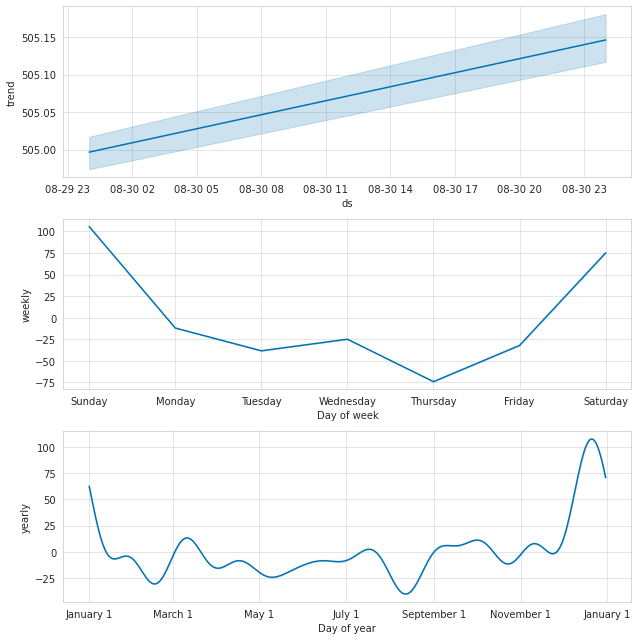

In [38]:
model.plot_components(y_pred)

In [39]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='360 days')
df_cv.tail()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-02-27 00:00:00 and 2016-08-20 00:00:00
  0%|          | 0/4 [00:00<?, ?it/s]

Initial log joint probability = -33.0155
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1514.86    0.00869266       91.6281           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       1515.82    0.00235702       152.919   2.609e-05       0.001      190  LS failed, Hessian reset 
     199       1516.82   3.55008e-05       70.4117      0.5894      0.5894      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1517.74     0.0155762       120.621           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       1517.93   0.000514738       94.7033   6.711e-06       0.001      526  LS failed, Hessian reset 
     399       1518.32   0.000554352       71.5402      0.8357      0.8357      612   
    Iter      log pro

 25%|██▌       | 1/4 [00:01<00:05,  1.74s/it]

Initial log joint probability = -28.2632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1823.92   0.000621393       84.9417       1.236      0.1236      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1825.35   0.000578904       107.845   6.484e-06       0.001      189  LS failed, Hessian reset 
     161       1826.57    0.00103872       92.8428   1.528e-05       0.001      274  LS failed, Hessian reset 
     199       1826.86    0.00020861       91.4933     0.06509           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       1826.91   6.82529e-05       72.1304    1.13e-06       0.001      377  LS failed, Hessian reset 
     291       1827.28   0.000293473       85.9668   4.833e-06       0.001      503  LS failed, Hessian reset 
     299       1827.31   0.000101524       53.6842      0.8661   

 50%|█████     | 2/4 [00:03<00:03,  1.87s/it]

Initial log joint probability = -27.4926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2277.84   0.000289257       78.8704   2.314e-06       0.001      150  LS failed, Hessian reset 
      99       2278.62    0.00526021       107.435      0.3119           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2283.42     0.0171618       108.773           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2283.51   0.000662432       158.312   7.334e-06       0.001      335  LS failed, Hessian reset 
     296       2283.86   0.000324892       129.048   3.128e-06       0.001      498  LS failed, Hessian reset 
     299       2283.87   4.69481e-05       72.2991       0.919       0.919      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 75%|███████▌  | 3/4 [00:05<00:01,  1.86s/it]

Initial log joint probability = -24.0348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2700.87    0.00153724       150.421      0.7266      0.7266      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2703.06   0.000197839       46.1062      0.3752      0.3752      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219        2703.7   0.000636039       65.6282   1.332e-06       0.001      322  LS failed, Hessian reset 
     298       2703.91   0.000536345       66.3216   6.996e-06       0.001      491  LS failed, Hessian reset 
     299       2703.92   0.000148768       55.4844      0.8493      0.8493      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       2703.93    9.6598e-06       55.1897   1.653e-07       0.001      563  LS failed, Hessian rese

100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1431,2017-08-11,428.895128,350.597683,512.025304,463.733851,2016-08-20
1432,2017-08-12,533.207875,449.195886,614.108005,444.798280,2016-08-20
1433,2017-08-13,562.849862,480.747249,645.894066,485.768618,2016-08-20
1434,2017-08-14,454.303771,368.975187,537.242758,427.004717,2016-08-20
1435,2017-08-15,430.644218,347.047363,519.815062,427.980884,2016-08-20


In [40]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,3755.206591,61.279740,54.393262,0.153786,0.153631,0.664336
1,37 days,3840.763832,61.973896,55.037709,0.155422,0.157580,0.657343
2,38 days,4062.134755,63.734879,56.316938,0.158242,0.158713,0.643357
3,39 days,4301.145041,65.583116,57.755333,0.160544,0.160789,0.622378
4,40 days,4485.963228,66.977334,58.577647,0.162418,0.161316,0.610140


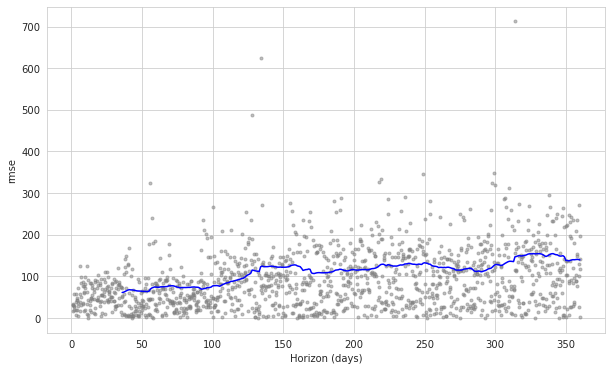

In [41]:
from fbprophet.plot import plot_cross_validation_metric
pic = plot_cross_validation_metric(df_cv, metric='rmse')

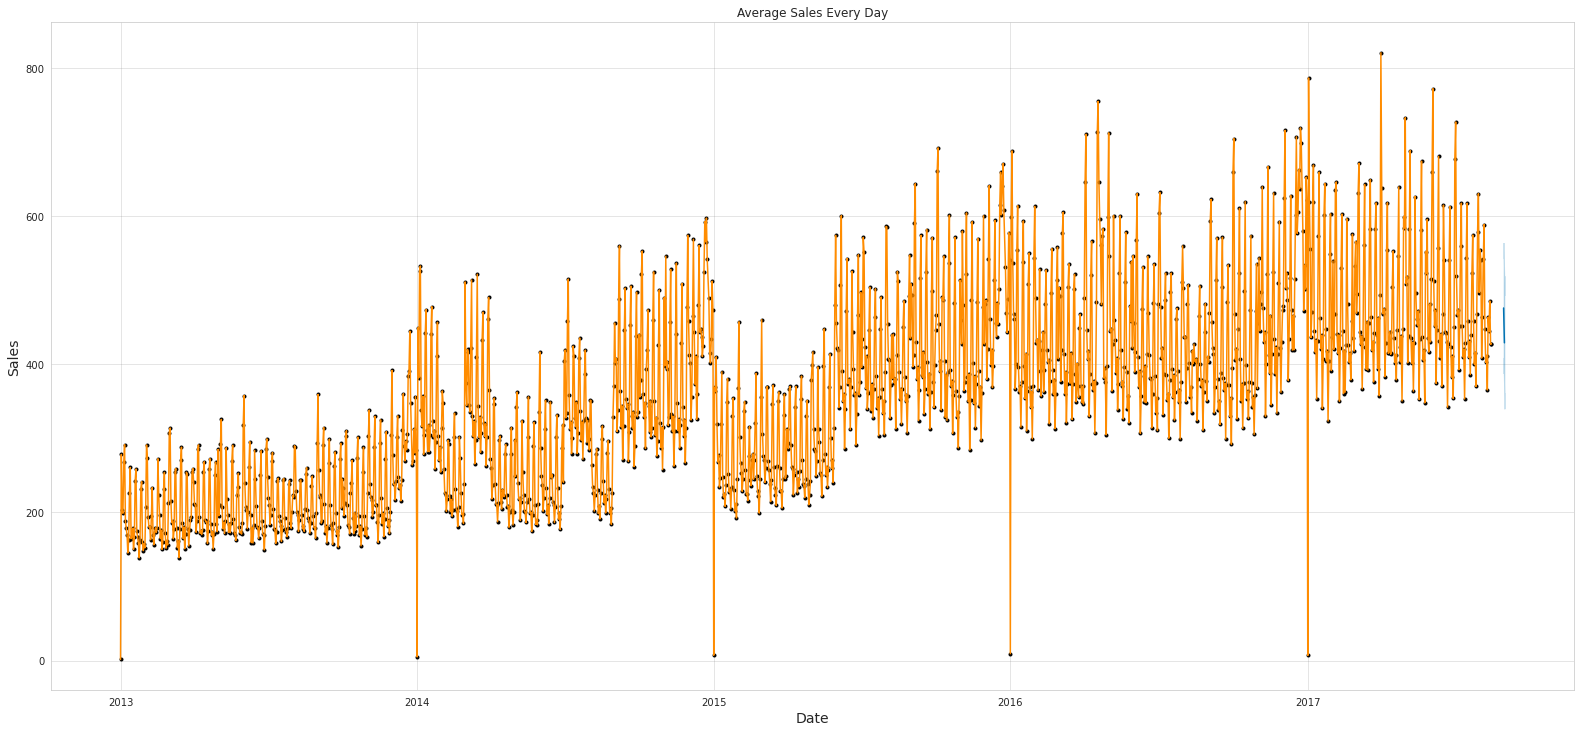

In [42]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') 
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales Every Day')

plt.show()

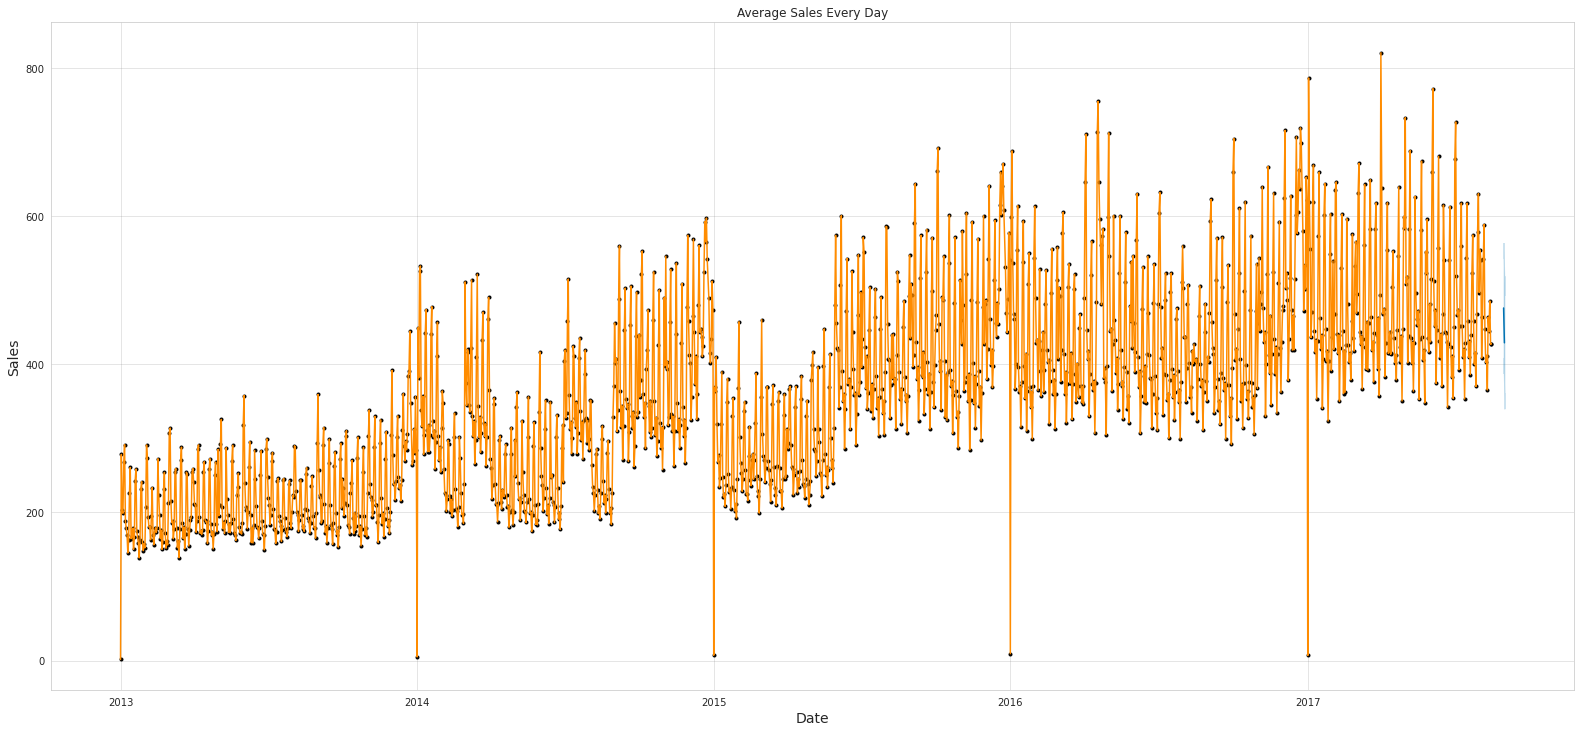

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model_load.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') 
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales Every Day')

plt.show()

In [44]:
df_train_2017 = df_data[df_data['date'] <= datetime.datetime(2017,8,15)]
y_train = df_train_2017[['sales','date']]
y_train['date'] = y_train.date.dt.to_period('D')
y_train = y_train.set_index('date')
y_train.tail()

,sales
date,
2017-08-15,438.133
2017-08-15,154.553
2017-08-15,2419.729
2017-08-15,121.000
2017-08-15,16.000


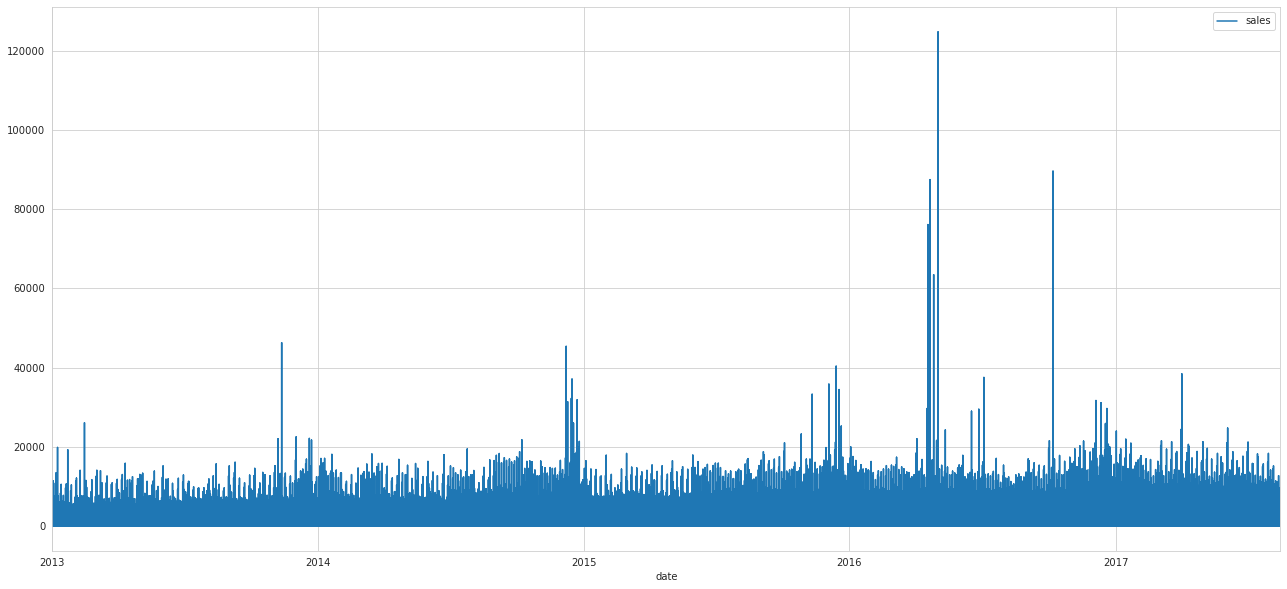

<Figure size 1440x720 with 0 Axes>

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)
plt.figure(figsize=(20, 10))
y_train.plot(ax=ax)
plt.show()